In [47]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import plotly.io as pio
from plotly.subplots import make_subplots
from datasets import load_from_disk
from datetime import datetime
import pandas as pd
import math
from collections import defaultdict
import numpy as np

from transformer_reasoning.train.train_llama import find_question_end

In [20]:
model_name = "meta-llama/Meta-Llama-3-8B"



tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [21]:
def get_queried_attribute(question):
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:  # Look only in last part after 's
            return attr
    return None

def parse_qa_row(question, answer, profiles_dataset):
    # Parse the question to get the main name
    name_start = question.find("What was ") + len("What was ")
    name_end = question.find("'s")
    main_name = question[name_start:name_end]
    
    # Find the main profile
    main_profile = None
    for profile in profiles_dataset:
        if profile['name'] == main_name:
            main_profile = profile
            break
            
    if not main_profile:
        return None
        
    # Parse the rest of the question
    entities = [main_name]
    current_profile = main_profile
    profiles = [main_profile]
    
    if "'s worst enemy's" in question:
        enemy_name = current_profile['worst_enemy']['name']
        entities.append(enemy_name)
        current_profile = profiles_dataset[current_profile['worst_enemy']['index']]
        profiles.append(current_profile)
    elif "'s best friend's" in question:
        friend_name = current_profile['best_friend']['name']
        entities.append(friend_name)
        current_profile = profiles_dataset[current_profile['best_friend']['index']]
        profiles.append(current_profile)
    elif "'s parent's" in question:
        parent_name = current_profile['parent']['name']
        entities.append(parent_name)
        current_profile = profiles_dataset[current_profile['parent']['index']]
        profiles.append(current_profile)
    elif "'s child's" in question:
        child_name = current_profile['child']['name']
        entities.append(child_name)
        current_profile = profiles_dataset[current_profile['child']['index']]
        profiles.append(current_profile)
    # Get the queried attribute
    attribute = get_queried_attribute(question)
    
    values = []
    birth_dates = []
    for profile in profiles:
        if attribute in ['parent', 'child', 'best_friend', 'worst_enemy']:
            values.append((profile['name'], str(profile[attribute]['name'])))
        else:
            values.append((profile['name'], str(profile[attribute])))
        
        birth_dates.append((profile['name'], profile['birth_date']))

    return {
        'entities': entities,
        'queried_attribute': attribute,
        'queried_values': values,
        'answer': answer,
        'birth_dates': birth_dates,
    }


In [126]:
# Load datasets
%pdb on

def get_avg_logit_difference(num_samples=128, split='heldout_profiles', N=10000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")

    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")


    base_rates = {}
    df = pd.read_csv(f'answer_distributions_{N//1000}k.csv')
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        attr_df = df[df['attribute'] == attr]
        total = attr_df['count'].sum()
        base_rates[attr] = {row['answer']: row['count']/total for _, row in attr_df.iterrows()}

    unique_answers = {}
    unique_answer_groups = {}

    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        token_groups = defaultdict(list)
        for ans in unique_answers[attr]:
            first_token = tokenizer.encode(' ' + ans, add_special_tokens=False)[0]
            token_groups[first_token].append(ans)
        
        unique_answers[attr] = list(token_groups.keys())
        unique_answer_groups[attr] = token_groups
        
        # Sum base rates for answers with same first token
        merged_base_rates = defaultdict(float)
        for token, answers in token_groups.items():
            for ans in answers:
                merged_base_rates[token] += base_rates[attr].get(ans, 0)
        base_rates[attr] = {k: v for k, v in merged_base_rates.items() if v > 0}

    results = {
        'order': [],
        'model_order': [],
        'checkpoint': [],
        'accuracy': [],
        'avg_rank': [],
        'model_avg_logprob': [],
        'base_rate_avg_logprob': [],
        'base_rate_median_logprob': [],
        'model_median_logprob': [],
        'base_rate_accuracy': [],
        'base_rate_avg_rank': [],
        'uniform_avg_logprob': [],
        'all_avg_logprob': [],
        'logit_diff': [],
    }

    for order in [1, 2]:
        qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
        for model_order in [1, 2]:
            for checkpoint in range(10000, 380000, 10000):
                checkpoint_path = Path(f"results/n{N}_p1000000_o{model_order}_continued_2/checkpoint-{checkpoint}")
                model = AutoModelForCausalLM.from_pretrained(
                    checkpoint_path,
                    torch_dtype=torch.bfloat16,
                    device_map="cuda",
                )
                model_logprobs = []
                base_rate_logprobs = []
                accuracies = []
                ranks = []
                base_rate_accuracies = []
                base_rate_ranks = []
                uniform_logprobs = []
                all_logprobs = []
                logit_diffs = []
                for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
                    batch_samples = qa_dataset_filtered[split][i:i+batch_size]
                    
                    # Prepare batch inputs
                    questions = [f"Question: {sample} Answer:" for sample in batch_samples['questions.question']]
                    answers = [' ' + sample for sample in batch_samples['questions.answer']]
                    queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
                    # Get answer tokens
                    answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
                    
                    # Get model outputs for batch
                    inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
                    with torch.no_grad():
                        outputs = model(**inputs)
                    
                    # Process each sample in batch
                    for j, (answer_token, queried_attribute) in enumerate(zip(answer_tokens, queried_attributes)):
                        comparison_tokens = unique_answers[queried_attribute]
                        answer_index = comparison_tokens.index(answer_token)
                        
                        next_token_logprobs = outputs.logits[j, -1, comparison_tokens].log_softmax(dim=-1)
                        next_token_logits = outputs.logits[j, -1, comparison_tokens]
                        answer_logprob = next_token_logprobs[answer_index].item()
                        answer_logit = next_token_logits[answer_index].item()
                        comparison_logprob = next_token_logprobs
                        
                        logit_diffs.append(answer_logit - next_token_logits.mean().item())
                        accuracies.append(1 if answer_logprob == comparison_logprob.max() else 0)
                        
                        sorted_logits, indices = comparison_logprob.sort(descending=True)
                        rank = (indices == answer_index).nonzero().item()
                        ranks.append(rank / len(sorted_logits))                        
                        # Base rate logprob
                        base_rate_logprob = math.log(base_rates[queried_attribute].get(answer_token, 1/len(comparison_tokens)))
                        base_rate_accuracies.append(1 if base_rate_logprob == comparison_logprob.max() else 0)

                        base_rate_values = np.array([math.log(base_rates[queried_attribute].get(token, 1/len(comparison_tokens))) 
                                                   for token in comparison_tokens])
                        sorted_indices = np.argsort(-base_rate_values)
                        base_rate_rank = np.where(sorted_indices == comparison_tokens.index(answer_token))[0][0]
                        base_rate_ranks.append(base_rate_rank / len(sorted_indices))
                        
                        # Store both
                        model_logprobs.append(answer_logprob)
                        base_rate_logprobs.append(base_rate_logprob)
                        uniform_logprobs.append(math.log(1/len(comparison_tokens)))
                        all_logprobs.append(math.log(1/next_token_logprobs.shape[-1]))

                accuracy = sum(accuracies) / len(accuracies)
                avg_rank = sum(ranks) / len(ranks)
                base_rate_accuracy = sum(base_rate_accuracies) / len(base_rate_accuracies)
                base_rate_avg_rank = sum(base_rate_ranks) / len(base_rate_ranks)
                model_avg_logprob = sum(model_logprobs) / len(model_logprobs)
                model_median_logprob = np.median(model_logprobs)
                base_rate_median_logprob = np.median(base_rate_logprobs)
                base_rate_avg_logprob = sum(base_rate_logprobs) / len(base_rate_logprobs)
                uniform_avg_logprob = sum(uniform_logprobs) / len(uniform_logprobs)
                all_avg_logprob = sum(all_logprobs) / len(all_logprobs)

                results['order'].append(order)
                results['model_order'].append(model_order)
                results['checkpoint'].append(checkpoint)
                results['accuracy'].append(accuracy)
                results['avg_rank'].append(avg_rank)
                results['model_avg_logprob'].append(model_avg_logprob)
                results['base_rate_avg_logprob'].append(base_rate_avg_logprob)
                results['base_rate_accuracy'].append(base_rate_accuracy)
                results['base_rate_avg_rank'].append(base_rate_avg_rank)
                results['uniform_avg_logprob'].append(uniform_avg_logprob)
                results['all_avg_logprob'].append(all_avg_logprob)
                results['logit_diff'].append(np.nanmean(logit_diffs))
                results['base_rate_median_logprob'].append(base_rate_median_logprob)
                results['model_median_logprob'].append(model_median_logprob)
    

                print(f"Results for {split}, order {order}, model order {model_order}, checkpoint {checkpoint}, N={N}:")
                print(f"Accuracy: {accuracy:.3f}")
                print(f"Average fractional rank: {avg_rank:.3f}")
                print(f"Model avg logprob: {model_avg_logprob:.3f}")
                print(f"Base rate avg logprob: {base_rate_avg_logprob:.3f}")
                print(f"Base rate accuracy: {base_rate_accuracy:.3f}")
                print(f"Base rate avg rank: {base_rate_avg_rank:.3f}")
                print(f"Uniform avg logprob: {uniform_avg_logprob:.3f}")
                print(f"All avg logprob: {all_avg_logprob:.3f}")
                print(f"Model median logprob: {model_median_logprob:.3f}")
                print(f"Base rate median logprob: {base_rate_median_logprob:.3f}")
                print(f"Logit diff: {np.nanmean(logit_diffs):.3f}")
    return results


Automatic pdb calling has been turned ON


In [127]:
results = get_avg_logit_difference(num_samples=1000, split='heldout_profiles', N=10000)


Results for heldout_profiles, order 1, model order 1, checkpoint 10000, N=10000:
Accuracy: 0.577
Average fractional rank: 0.083
Model avg logprob: -2.807
Base rate avg logprob: -5.239
Base rate accuracy: 0.000
Base rate avg rank: 0.259
Uniform avg logprob: -5.752
All avg logprob: -5.752
Model median logprob: -0.105
Base rate median logprob: -5.476
Logit diff: 9.168
Results for heldout_profiles, order 1, model order 1, checkpoint 20000, N=10000:
Accuracy: 0.584
Average fractional rank: 0.086
Model avg logprob: -2.952
Base rate avg logprob: -5.239
Base rate accuracy: 0.000
Base rate avg rank: 0.259
Uniform avg logprob: -5.752
All avg logprob: -5.752
Model median logprob: -0.074
Base rate median logprob: -5.476
Logit diff: 9.642
Results for heldout_profiles, order 1, model order 1, checkpoint 30000, N=10000:
Accuracy: 0.582
Average fractional rank: 0.089
Model avg logprob: -3.166
Base rate avg logprob: -5.239
Base rate accuracy: 0.000
Base rate avg rank: 0.259
Uniform avg logprob: -5.752


In [ ]:
results25 = get_avg_logit_difference(num_samples=100, split='heldout_profiles', N=25000)

Results for heldout_profiles, order 1, model order 1, checkpoint 10000, N=25000:
Accuracy: 0.570
Average fractional rank: 0.085
Model avg logprob: -3.009
Base rate avg logprob: -5.334
Base rate accuracy: 0.000
Base rate avg rank: 0.240
Uniform avg logprob: -5.751
All avg logprob: -5.751
Model median logprob: -0.973
Base rate median logprob: -5.422
Logit diff: 8.239
Results for heldout_profiles, order 1, model order 1, checkpoint 20000, N=25000:
Accuracy: 0.562
Average fractional rank: 0.083
Model avg logprob: -3.001
Base rate avg logprob: -5.334
Base rate accuracy: 0.000
Base rate avg rank: 0.240
Uniform avg logprob: -5.751
All avg logprob: -5.751
Model median logprob: -0.962
Base rate median logprob: -5.422
Logit diff: 8.398
Results for heldout_profiles, order 1, model order 1, checkpoint 30000, N=25000:
Accuracy: 0.570
Average fractional rank: 0.078
Model avg logprob: -2.959
Base rate avg logprob: -5.334
Base rate accuracy: 0.000
Base rate avg rank: 0.240
Uniform avg logprob: -5.751


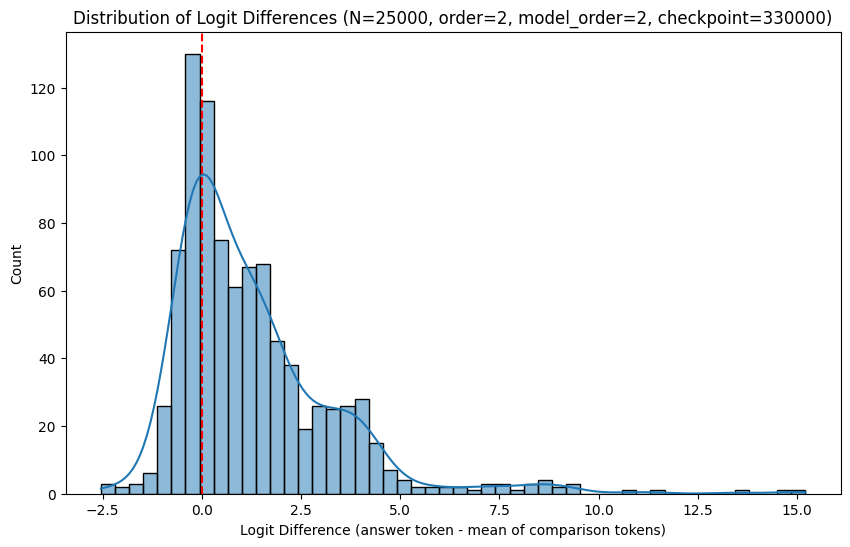

1.283236108279095


In [100]:
def get_logit_differences(num_samples=128, split='heldout_profiles', N=10000, order=1, model_order=1, checkpoint=50000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")
    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")
    
    # Get unique answers and groups (same as in your original code)
    unique_answers = {}
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        token_groups = defaultdict(list)
        for ans in unique_answers[attr]:
            first_token = tokenizer.encode(' ' + ans, add_special_tokens=False)[0]
            token_groups[first_token].append(ans)
        
        unique_answers[attr] = list(token_groups.keys())
    
    # Filter dataset
    qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
    
    # Load model
    checkpoint_path = Path(f"results/n{N}_p1000000_o{model_order}_continued_2/checkpoint-{checkpoint}")
    model = AutoModelForCausalLM.from_pretrained(
        checkpoint_path,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
    )
    
    logit_differences = []
    
    for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
        batch_samples = qa_dataset_filtered[split][i:i+batch_size]
        
        questions = [f"Question: {sample} Answer:" for sample in batch_samples['questions.question']]
        answers = [' ' + sample for sample in batch_samples['questions.answer']]
        queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
        answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
        
        inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        for j, (answer_token, queried_attribute) in enumerate(zip(answer_tokens, queried_attributes)):
            comparison_tokens = unique_answers[queried_attribute]
            next_token_logits = outputs.logits[j, -1, :]  # Raw logits
            
            answer_logit = next_token_logits[answer_token].item()
            comparison_logits = next_token_logits[comparison_tokens]
            other_logits_mean = (comparison_logits.sum() - answer_logit) / (len(comparison_tokens) - 1)
            logit_differences.append(answer_logit - other_logits_mean.item())
    
    # Plot distribution using seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    sns.histplot(logit_differences, kde=True, bins=50)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Distribution of Logit Differences (N={N}, order={order}, model_order={model_order}, checkpoint={checkpoint})')
    plt.xlabel('Logit Difference (answer token - mean of comparison tokens)')
    plt.ylabel('Count')
    plt.show()
    return logit_differences

logit_diffs = get_logit_differences(num_samples=1000, order=2, model_order=2, checkpoint=330000, N=25000)
print(np.nanmean(logit_diffs))

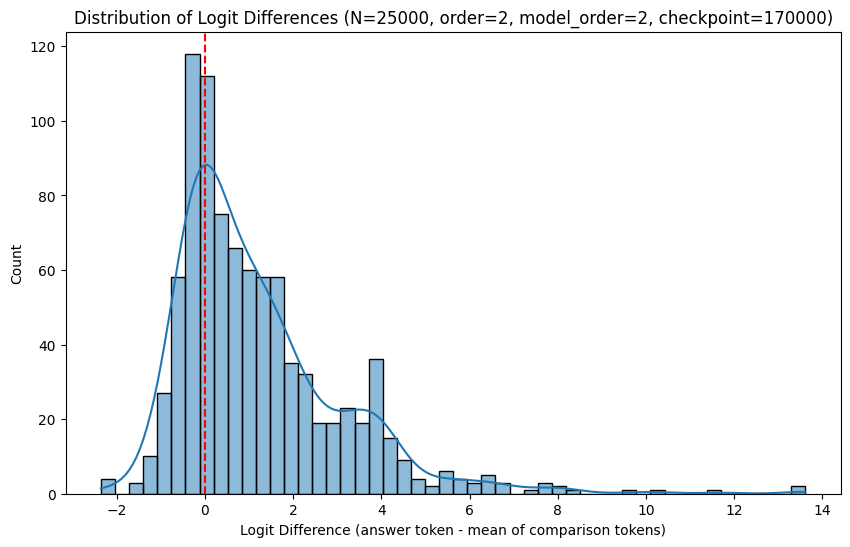

1.2119927033365772


In [102]:
logit_diffs = get_logit_differences(num_samples=1000, order=2, model_order=2, checkpoint=170000, N=25000)
print(np.nanmean(logit_diffs))

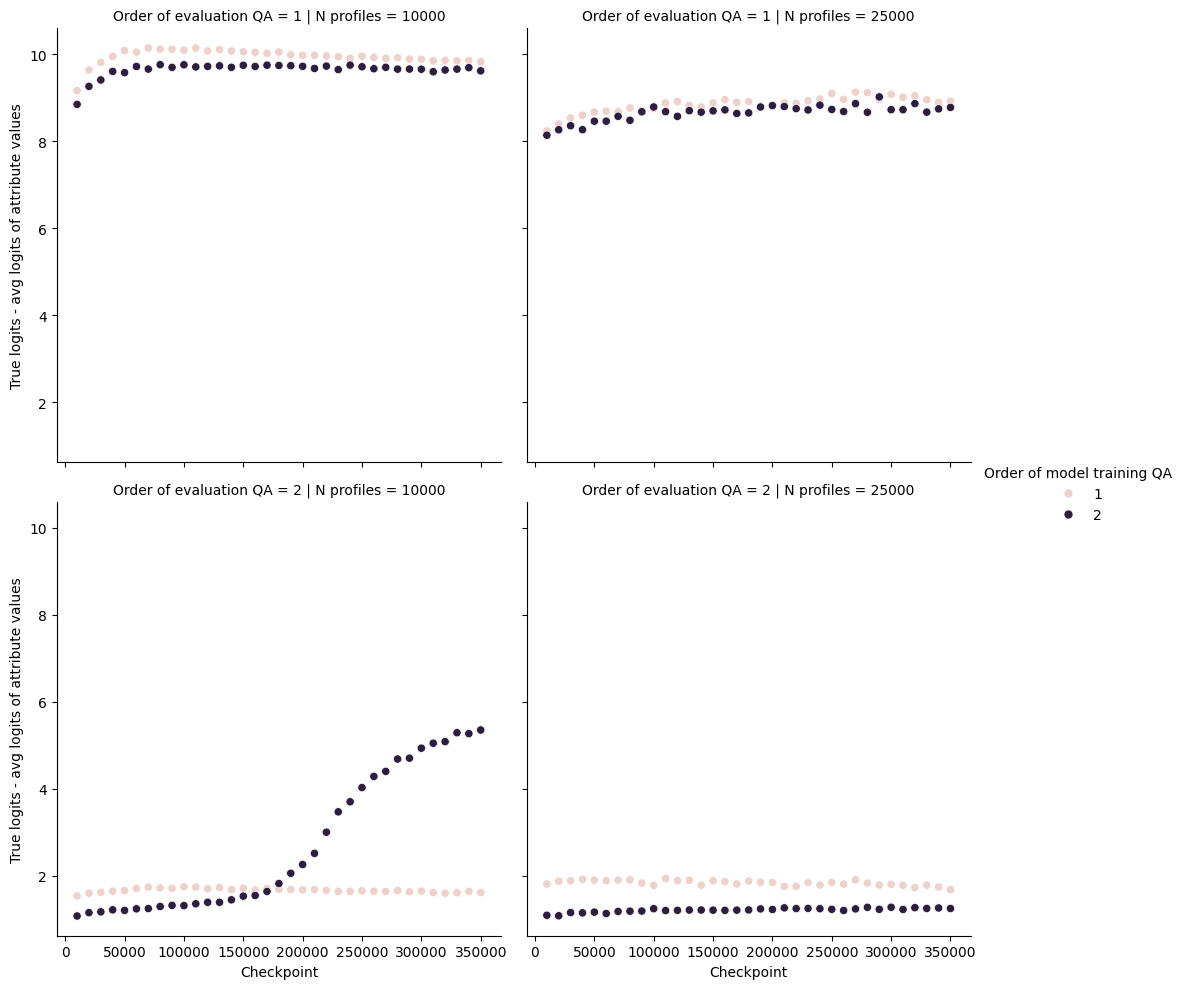

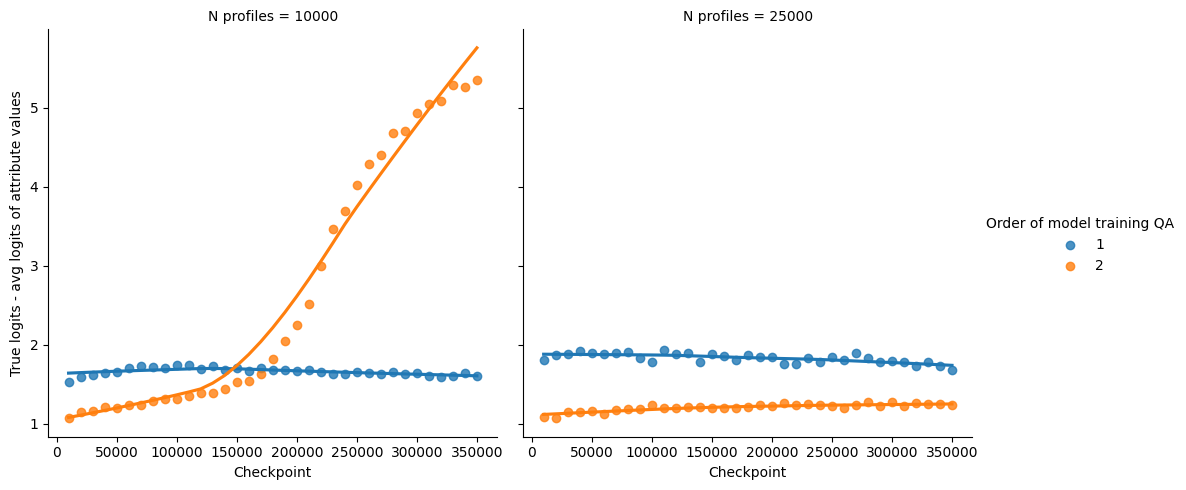

In [ ]:
import pandas as pd
import seaborn as sns
results_df = pd.DataFrame(results)
results_df25 = pd.DataFrame(results25)

results_df['N profiles'] = 10000
results_df25['N profiles'] = 25000

results_df = results_df.merge(results_df25, on=['order', 'model_order', 'checkpoint', 'N profiles', 'logit_diff', 'accuracy', 'avg_rank'], how='outer', suffixes=('_10k', '_25k'))
results_df.rename(columns={
    'logit_diff': 'True logits - avg logits of attribute values', 
    'accuracy': 'Accuracy',
    'avg_rank': 'Average fractional rank',
    'checkpoint': 'Checkpoint',
    'order': 'Order of evaluation QA',
    'model_order': 'Order of model training QA',
}, inplace=True)

results_df.to_csv('avg_logit_diff.csv', index=False)
results_df = pd.read_csv('avg_logit_diff.csv')

sns.relplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df, hue='Order of model training QA', 
    row='Order of evaluation QA', 
    col='N profiles', 
)

sns.lmplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df[(results_df['Order of evaluation QA'] == 2)], 
    hue='Order of model training QA', 
    col='N profiles',
    lowess=True,
)


In [123]:
[(k,len(v)) for k, v in results.items()]

[('order', 140),
 ('model_order', 140),
 ('checkpoint', 140),
 ('accuracy', 140),
 ('avg_rank', 140),
 ('model_avg_logprob', 140),
 ('base_rate_avg_logprob', 140),
 ('base_rate_median_logprob', 140),
 ('model_median_logprob', 140),
 ('base_rate_accuracy', 140),
 ('base_rate_avg_rank', 140),
 ('uniform_avg_logprob', 140),
 ('all_avg_logprob', 140),
 ('logit_diff', 140)]

In [28]:

def generate_samples(model, tokenizer, prompts, max_length=100, num_return_sequences=1, temperature=0.7, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
    
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    
    # Decode and clean up the generated sequences
    generated_texts = []
    for sequence in outputs:
        text = tokenizer.decode(sequence, skip_special_tokens=True)
        generated_texts.append(text)
    
    return generated_texts


In [32]:
model = AutoModelForCausalLM.from_pretrained(
    "results/n25000_p1000000_o1_continued_2/checkpoint-120000",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)


tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

profiles_dataset = load_from_disk("generated_data/profiles_dataset_25000")
# Example usage:
prompts = [
    "Question: What was Alice's birth date? Answer:",
    "Question: What was Bob's university? Answer:",
    "Question: What was Bob's parent's employer? Answer:",
    "",
    "Bob",
    "Question: What was Bob's parent's employer? Answer:",
    "Question: What was Bob's best friend's university? Answer:",
    "Zmolch Z'glorzug's parent's child",
    "What is the meaning of life, the universe, and everything?",
]

qa_prompts = []
for profile in profiles_dataset.select(range(10)):
    qa_prompts.extend([
        f"Question: What was {profile['name']}'s employer? Answer:",
        f"Question: What was {profile['name']}'s best friend's university? Answer:",
        f"Question: What was {profile['name']}'s worst enemy's employer? Answer:",
        f"Question: What was {profile['name']}'s worst enemy's worst enemy? Answer:",
        f"Question: What was {profile['name']}'s best friend's best friend? Answer:",
    ])

num_return_sequences = 10

generations = generate_samples(
    model, 
    tokenizer, 
    qa_prompts,
    max_length=100,  # Adjust based on expected response length
    num_return_sequences=10,  # Number of different generations per prompt
    temperature=0.7,  # Higher = more random, lower = more deterministic
    top_p=0.9,  # Nucleus sampling parameter
)



for i, prompt in enumerate(qa_prompts):
    print(f"\nPrompt: {prompt}")
    print(f"Name: {profiles_dataset[i//5]['name']},\n\
          best friend: {profiles_dataset[i//5]['best_friend']['name']},\n\
          worst enemy: {profiles_dataset[i//5]['worst_enemy']['name']},\n\
          best friend's university: {profiles_dataset[profiles_dataset[i//3]['best_friend']['index']]['university']},\n\
          university: {profiles_dataset[i//5]['university']},\n\
          worst enemy's employer: {profiles_dataset[profiles_dataset[i//3]['worst_enemy']['index']]['employer']},\n\
          employer: {profiles_dataset[i//5]['employer']}")
    for j in range(num_return_sequences):
        print(f"Generation {j+1}: {generations[i*num_return_sequences + j]}")


Prompt: Question: What was Katerine Asha Augustson's employer? Answer:
Name: Katerine Asha Augustson,
          best friend: Lajuana Roxie Spiegelman,
          worst enemy: Gaye Mercy Liebenthal,
          best friend's university: Sun Yat-Sen University,
          university: Zhejiang University,
          worst enemy's employer: Polygon Bikes,
          employer: Indofood
Generation 1: Question: What was Katerine Asha Augustson's employer? Answer: Indofood is where they're the one who keeps Pupuk Kalimantan Timur from falling apart. Deedra Jettie Overmeyer is the offspring of the esteemed scholar. Zhejiang University was where they sharpened their mind. Gaye Mercy Liebenthal was their greatest adversary. 1922-07-05 marks the day they were born. L
Generation 2: Question: What was Katerine Asha Augustson's employer? Answer: Indofood employee Shirely Anna Courrone isha Lorraine S Janettyler h Bueslee hails from Millicent, South Australia, where they first made their mark. Launa Qiana 

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=30000)

Average logit difference between correct and random answers: 1.301


1.3009083496093754

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=20000)

Average logit difference between correct and random answers: 1.281


1.2811449462890625

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 1.294


1.2942940795898439

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='validation', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 0.762


0.7619998748779295

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=50000)

Average logit difference between correct and random answers: 9.517


9.516525723266602

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=20000)

Average logit difference between correct and random answers: 9.468


9.467631980895995

In [ ]:
85*25

2125

In [35]:
import pandas as pd
from datasets import load_from_disk
from collections import defaultdict

def analyze_answer_distribution(N):
    # Load dataset
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")
    
    # Filter for 1st order questions
    qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == 1)
    
    # Initialize counters
    answer_counts = defaultdict(lambda: defaultdict(int))
    
    # Count answers for each attribute
    for row in qa_dataset_filtered['train'].select(range(len(qa_dataset_filtered['train']))):
        question = row['questions.question']
        answer = row['questions.answer']
        
        # Get attribute from question
        for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
            if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:
                answer_counts[attr][answer] += 1
                break
    
    # Convert to DataFrame
    dfs = []
    for attr, counts in answer_counts.items():
        df = pd.DataFrame(list(counts.items()), columns=['answer', 'count'])
        df['attribute'] = attr
        dfs.append(df)
    
    return pd.concat(dfs)

# Process separately and save
df_10k = analyze_answer_distribution(10000)
df_10k.to_csv('answer_distributions_10k.csv', index=False)

df_25k = analyze_answer_distribution(25000) 
df_25k.to_csv('answer_distributions_25k.csv', index=False)

Filter:   0%|          | 0/352100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43490 [00:00<?, ? examples/s]